In [ ]:
import kagglehub
path = kagglehub.dataset_download("phucthaiv02/butterfly-image-classification")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'butterfly-image-classification' dataset.
Path to dataset files: /kaggle/input/butterfly-image-classification


In [ ]:
import shutil, os  #importing python modules: shutil (for copying), os (for interacting with os)
dest_dir = "/content/butterfly_dataset"
if not os.path.exists(dest_dir):
    shutil.copytree(path, dest_dir)
print("Dataset copied to:", dest_dir)

Dataset copied to: /content/butterfly_dataset


In [ ]:
import pandas as pd
data_path = 'butterfly_dataset/train'
df = pd.read_csv('butterfly_dataset/Training_set.csv')

In [ ]:
df.head()

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

In [ ]:
print(train_df,test_df)

            filename                     label
4490  Image_4491.jpg          MANGROVE SKIPPER
4800  Image_4801.jpg                 GREAT JAY
397    Image_398.jpg             SLEEPY ORANGE
6140  Image_6141.jpg                 CLEOPATRA
973    Image_974.jpg              PAINTED LADY
...              ...                       ...
2885  Image_2886.jpg  BANDED ORANGE HELICONIAN
4656  Image_4657.jpg             DANAID EGGFLY
4543  Image_4544.jpg  GREEN CELLED CATTLEHEART
612    Image_613.jpg             BECKERS WHITE
511    Image_512.jpg                  POPINJAY

[5199 rows x 2 columns]             filename           label
4099  Image_4100.jpg   BECKERS WHITE
6403  Image_6404.jpg     BLUE MORPHO
5729  Image_5730.jpg   CRIMSON PATCH
1233  Image_1234.jpg      PAPER KITE
656    Image_657.jpg          ULYSES
...              ...             ...
3531  Image_3532.jpg  ORANGE OAKLEAF
2593  Image_2594.jpg    EASTERN COMA
5275  Image_5276.jpg     GOLD BANDED
2661  Image_2662.jpg       CLEOPATRA
5984

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,  # divides pixel value (0-255) by 255 --> scale them to (0-1)
                                   rotation_range=20,   # randomly rotates images upto +-20
                                   width_shift_range=0.2,   # randomly shifts images horizontally up to 20%
                                   height_shift_range=0.2,   # randomly shifts images vertically up to 20%
                                   shear_range=0.2,   # applies random shearing
                                   zoom_range=0.2,  # randomly zooms in/out up to 20%
                                   horizontal_flip=True)   # randomly flips images horizontally

test_datagen = ImageDataGenerator(rescale=1./255)

image_dir = "/content/butterfly_dataset/train"

#resize --> augmentation --> batches --> predict

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(128,128),   # every image will be resized to 128 * 128 pixels
    batch_size=32,   # it will produce batches of 32 images at a time
    class_mode='categorical'  # multi-class classification
)

test_gen = test_datagen.flow_from_dataframe(   #.flow_from_dataframe --> method of ImageDataGenerator
    dataframe=test_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical'
)

Found 5199 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),  # (height, width, channels: 1--> grey scale, 3--> rgb)
    MaxPooling2D(2,2),  # for each 2*2 block--> takes the maximum value (the strongest feature)

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  #ignores 50% of neurons while training to prevent overfitting
    Dense(75, activation='softmax')  #75 neurons --> 75 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  #categorical_crossentropy --> loss function for classification
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 75)             │         9,675 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,314,315 (12.64 MB)

 Trainable params: 3,314,315 (12.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=30  # the model will repeat the full training set 30 times
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.0210 - loss: 4.3158 - val_accuracy: 0.0477 - val_loss: 4.0808
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.0515 - loss: 4.0553 - val_accuracy: 0.1346 - val_loss: 3.4723
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.0962 - loss: 3.6330 - val_accuracy: 0.1746 - val_loss: 3.1723
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.1427 - loss: 3.3830 - val_accuracy: 0.3277 - val_loss: 2.6699
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.1802 - loss: 3.1498 - val_accuracy: 0.3315 - val_loss: 2.4193
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.2203 - loss: 2.9315 - val_accuracy: 0.3469 - val_loss: 2.3556
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.2640 - loss: 2.7456 - val_accuracy: 0.4223 - val_loss: 2.0863
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.2830 - loss: 2.6310 - val_accu

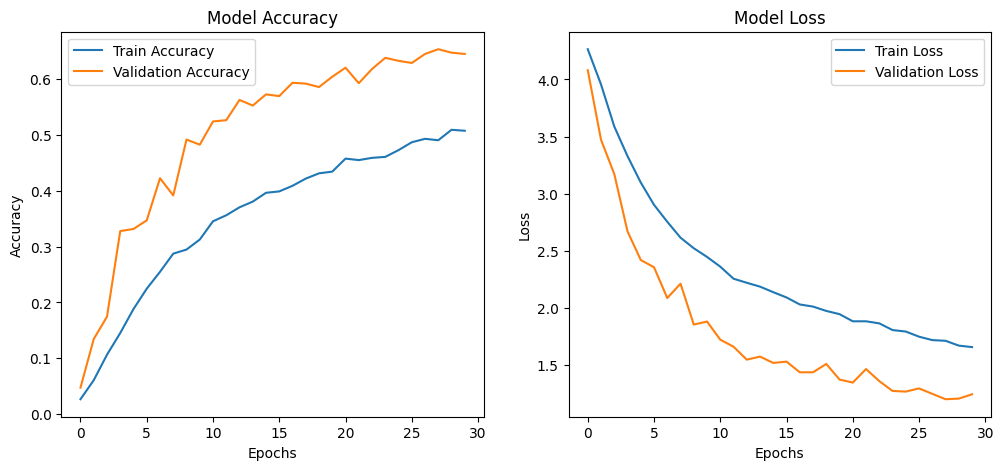

In [ ]:
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
loss, acc = model.evaluate(test_gen)
print(f"Test Accuracy: {acc*100:.2f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 307ms/step - accuracy: 0.6522 - loss: 1.1636
Test Accuracy: 64.46%


In [ ]:
model.save("butterfly_classifier.h5")  # .h5 --> file format used to store large amounts of numerical data efficiently
print("Model saved as butterfly_classifier.h5")

✅ Model saved as butterfly_classifier.h5


In [67]:
from tensorflow.keras.models import load_model
from google.colab import files

model = load_model("butterfly_classifier.h5")

uploaded = files.upload()

# swaps the key-value pair (inorder to return the class name not label)
class_labels = {v:k for k,v in train_gen.class_indices.items()}  # keys --> class names, values --> integer labels

for fn in uploaded.keys():
    img = image.load_img(fn, target_size=(128,128))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # expands the dimensions like (batch_size,height,width,channels)

    prediction = model.predict(img_array)
    pred_label = class_labels[np.argmax(prediction)]
    print(f"Prediction for {fn}: {pred_label}")

Saving SILVER SPOT SKIPPER.jpg to SILVER SPOT SKIPPER.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
Prediction for SILVER SPOT SKIPPER.jpg: SILVER SPOT SKIPPER


In [68]:
from google.colab import files
files.download("butterfly_classifier.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [69]:
import json

class_labels = {v: k for k, v in train_gen.class_indices.items()}

with open("class_labels.json", "w") as f:
    json.dump(class_labels, f)

from google.colab import files
files.download("class_labels.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>